# Twitter Spam Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn import cross_validation, grid_search, metrics, neighbors, tree, naive_bayes, ensemble, svm, calibration, feature_selection, pipeline ,preprocessing

pd.set_option("display.max_columns",60)

/Users/daniilskokleenko/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/daniilskokleenko/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Dataset - Social honeypot icwsm 2011

In [2]:
#Спамеры
content_polluters = pd.read_table('./content_polluters.txt', header=None, names = [
    "UserID",
    "ProfileCreatedAt",
    "ProfileCollectedAt",
    "NumberOfFollowings",
    "NumberOfFollowers",
    "NumberOfTweets",
    "LengthOfScreenName",
    "LengthOfDesc"])
content_polluters_tweets = pd.read_table('./content_polluters_tweets.txt', header=None, names = [
    "UserID",
    "TweetID",
    "Tweet",
    "TweetCreatedAt"
])

In [3]:
# Пользователь 1:1 Твит (последний по дате публикации)
content_polluters = content_polluters.set_index("UserID")
content_polluters_tweets_distinct = content_polluters_tweets.sort_values('TweetCreatedAt', ascending = False).groupby(['UserID']).first()

In [4]:
#Легитимные пользователи
legitimate_users = pd.read_table('./legitimate_users.txt', header=None, names = [
    "UserID",
    "ProfileCreatedAt",
    "ProfileCollectedAt",
    "NumberOfFollowings",
    "NumberOfFollowers",
    "NumberOfTweets",
    "LengthOfScreenName",
    "LengthOfDesc"])
legitimate_users_tweets = pd.read_table('./legitimate_users_tweets.txt', header=None, names = [
    "UserID",
    "TweetID",
    "Tweet",
    "TweetCreatedAt"
])

In [5]:
# Пользователь 1:1 Твит (последний по дате публикации)
legitimate_users = legitimate_users.set_index("UserID")
legitimate_users_tweets_distinct = legitimate_users_tweets.sort_values('TweetCreatedAt', ascending = False).groupby(['UserID']).first()

In [6]:
# List of spamwords
with open("blacklist.txt", "r", encoding='utf-8') as f:
    spamwords=f.read().splitlines()

In [7]:
spammers = pd.concat([content_polluters, content_polluters_tweets_distinct], axis=1, join='inner')
spammers['IsSpammer'] = 1

nonspammers =  pd.concat([legitimate_users, legitimate_users_tweets_distinct], axis=1, join='inner')
nonspammers['IsSpammer'] = 0

data = pd.concat([spammers, nonspammers])

## Additional features extraction

In [8]:
#User features
data["ProfileCreatedAt"] = pd.to_datetime(data["ProfileCreatedAt"])
data["ProfileCollectedAt"] = pd.to_datetime(data["ProfileCollectedAt"])
data["AccountAge"] = (data["ProfileCollectedAt"] - data["ProfileCreatedAt"]).astype('timedelta64[h]')

data["Flwrs/Flwngs"] = data["NumberOfFollowers"].divide(data["NumberOfFollowings"], fill_value=True)
data["Flwrs/Flwngs"].replace(np.inf, data["NumberOfFollowers"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["Reputation"] = data["NumberOfFollowers"].divide((data["NumberOfFollowers"] + data["NumberOfFollowings"]), fill_value=True)
data["Reputation"].replace(np.inf, data["NumberOfFollowers"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["FlwngsIncrease"] = data["NumberOfFollowings"].divide(data["AccountAge"])
data["FlwngsIncrease"].replace(np.inf, data["NumberOfFollowings"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["TweetsPerDay"]  = data["NumberOfTweets"].divide((data["AccountAge"] / 24), fill_value=True)
data["TweetsPerDay"].replace(np.inf, data["NumberOfTweets"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["TweetsPerWeek"]  = data["NumberOfTweets"].divide((data["AccountAge"] / (24 * 7)), fill_value=True)
data["TweetsPerWeek"].replace(np.inf, data["NumberOfTweets"], inplace = True)
data.replace(np.nan, 0, inplace = True)

In [9]:
def clean_tweet(row):
    tweet = row["TweetWordsList"]
    cl_tweet = []
    for word in tweet:
        m = re.match("https://\S+|http://\S+|bit.ly\S+", word)
        if word[0] not in ['@', '#'] and not m:
            cl_tweet.append(word)
    return ' '.join(cl_tweet)

In [10]:
def count_urls(row):
    tweet = row["TweetWordsList"]
    urls = 0
    for word in tweet:
        m = re.match("https://\S+|http://\S+|bit.ly\S+", word)
        if m:
            urls += 1
    return urls

In [11]:
def count_hashtags(row):
    tweet = row["TweetWordsList"]
    hashtags = 0
    for word in tweet:
        if word[0] == '#':
            hashtags += 1
    return hashtags

In [12]:
def count_mentions(row):
    tweet = row["TweetWordsList"]
    mentions = 0
    for word in tweet:
        if word[0] == '@':
            mentions += 1
    return mentions

In [13]:
def count_uppercases(row):
    tweet = row["CleanTweetWordsList"]
    uppercases = 0
    for word in tweet:
        if word[0].isupper():
            uppercases += 1
    return uppercases

In [14]:
def longest_word(row):
    tweet = row["CleanTweetWordsList"]
    maxword = 0
    for word in tweet:
        if len(word) > maxword:
            maxword = len(word)
    return maxword

In [15]:
def average_word(row):
    tweet = row["CleanTweetWordsList"]
    sum = 0
    count = 0
    for word in tweet:
        sum += len(word)
        count += 1
    try:
        avg = sum/count
        return avg
    except ZeroDivisionError as e:
        return 0

In [16]:
def count_spamwords(row):
    tweet = row["CleanTweetWordsList"]
    spam = 0
    for word in tweet:
        if word in spamwords:
            spam += 1
    return spam

In [17]:
data["TweetWordsList"] = data["Tweet"].str.split()
data['CleanTweet'] = data.apply(clean_tweet,axis=1)
data["CleanTweetWordsList"] = data["CleanTweet"].str.split()

In [18]:
#Content features
data["NumberOfWords"] = data["CleanTweet"].str.count(' ') + 1
data["NumberOfWords"].replace(1, 0, inplace = True)

data["NumberOfSymbols"] = data["Tweet"].str.len()

data["NumberOfSpaces"] = data["Tweet"].str.count(' ')

data["NumberOfCl"] = data.apply(count_uppercases,axis=1)

data["ClperWord"] = data["NumberOfCl"].divide(data["NumberOfWords"])
data["ClperWord"].replace(np.inf, data["NumberOfCl"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data['MaxWord'] = data.apply(longest_word,axis=1)

data['AvgWord'] = data.apply(average_word,axis=1)

data["NumberOfEm"] = data["Tweet"].str.count('\!')

data["NumberOfQm"] = data["Tweet"].str.count('\?')

data["NumberOfURLs"] = data.apply(count_urls,axis=1)

data["URLperWord"] = data["NumberOfURLs"].divide(data["NumberOfWords"])
data["URLperWord"].replace(np.inf, data["NumberOfURLs"], inplace = True)
data.replace(np.nan, 0, inplace = True)


data["NumberOfMentions"] = data.apply(count_mentions,axis=1)

data["MentionsperWord"] = data["NumberOfMentions"].divide(data["NumberOfWords"])
data["MentionsperWord"].replace(np.inf, data["NumberOfMentions"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["NumberOfHashtags"] = data.apply(count_hashtags,axis=1)

data["HashtagsperWord"] = data["NumberOfHashtags"].divide(data["NumberOfWords"])
data["HashtagsperWord"].replace(np.inf, data["NumberOfHashtags"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["NumberOfSpamWords"] = data.apply(count_spamwords,axis=1)

data["SpamWordsperWord"] = data["NumberOfSpamWords"].divide(data["NumberOfWords"])
data["SpamWordsperWord"].replace(np.inf, data["NumberOfSpamWords"], inplace = True)
data.replace(np.nan, 0, inplace = True)

In [19]:
# Drop Tweets longer than 140 chars 
data = data.drop(data[data.NumberOfSymbols > 140].index)

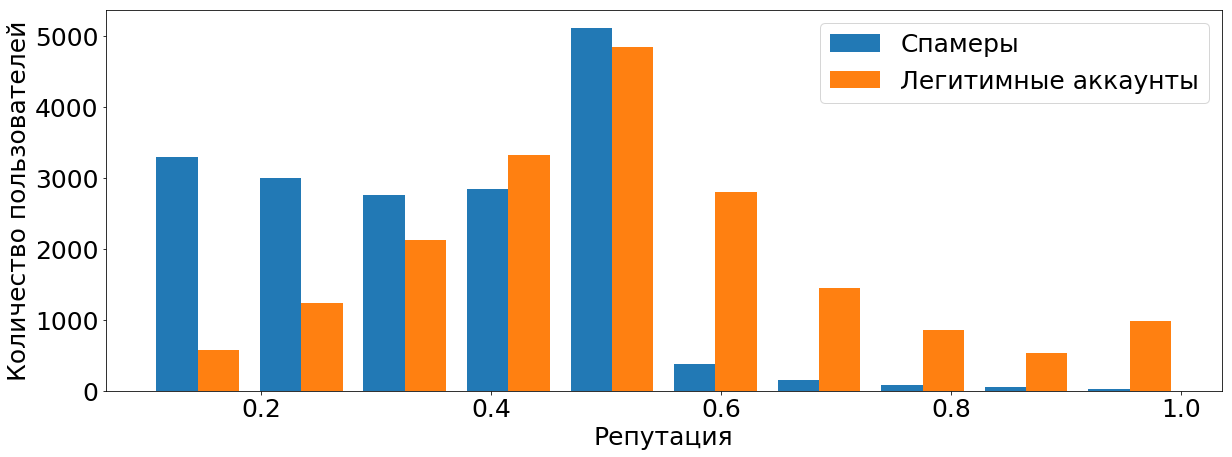

In [20]:
plt.rcParams['figure.figsize'] = (20,7)
plt.rcParams['font.size'] = 25   

data0=data[data.Reputation > .1]
plt.hist([data0[data0.IsSpammer==1].Reputation.values,
          data0[data0.IsSpammer==0].Reputation.values],
          label = ['Спамеры', 'Легитимные аккаунты'],
          alpha = .99)
plt.legend()
plt.xlabel("Репутация")
plt.ylabel("Количество пользователей")
plt.show()

In [21]:
feature_cols = { "UserFeatures" : [
                                "LengthOfScreenName",
                                "LengthOfDesc",
                                "NumberOfFollowings",
                                "NumberOfFollowers",
                                "NumberOfTweets",
                                "AccountAge",
                                "Flwrs/Flwngs",
                                "Reputation",
                                "FlwngsIncrease",
                                "TweetsPerDay",
                                "TweetsPerWeek"
                                ],
               "ContentFeatures":[ 
                                  "NumberOfWords",
                                  "NumberOfSymbols",
                                  "NumberOfSpaces",
                                  "NumberOfCl",
                                  "ClperWord",
                                  "MaxWord",
                                  "AvgWord",
                                  "NumberOfEm",
                                  "NumberOfQm",
                                  "NumberOfURLs",
                                  "URLperWord",
                                  "NumberOfHashtags",
                                  "HashtagsperWord",
                                  "NumberOfMentions",
                                  "MentionsperWord",
                                  "NumberOfSpamWords",
                                  "SpamWordsperWord"
                                ],
 
               }
X = data[feature_cols["UserFeatures"] + feature_cols["ContentFeatures"]]
Y = data['IsSpammer']

In [22]:
#Normalize data
X = (X - X.mean())/ ((X.max() - X.min())/2)

In [23]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, train_size=0.4, random_state = 0)

In [24]:
def print_report(RealValues, PredictedValues ):
    print('Accuracy: ' + str(metrics.accuracy_score(RealValues, PredictedValues)))
    print('\n' + 'Classification report:')
    print(metrics.classification_report(RealValues, PredictedValues))
    print('\n' + 'Confusion matrix: ')
    print(metrics.confusion_matrix(RealValues, PredictedValues))

def print_cross_validation(model, X, Y):
    scores = cross_validation.cross_val_score(model, X, Y, cv=10, scoring='accuracy')
    print(scores)
    print('Cross Validation Score: ' + str(scores.mean()))

In [25]:
cv = cross_validation.StratifiedShuffleSplit(Y_train, n_iter = 10, test_size = 0.2, random_state = 0)

## Naive Bayes

In [26]:
bern = naive_bayes.BernoulliNB()
bern.get_params().keys()

dict_keys(['alpha', 'binarize', 'class_prior', 'fit_prior'])

In [27]:
parameters_grid = {
    'fit_prior' : [True, False],
}

In [28]:
grid_cv = grid_search.GridSearchCV(bern, parameters_grid, scoring = 'accuracy', cv = cv)

In [29]:
%%time
grid_cv.fit(X_train, Y_train)

CPU times: user 954 ms, sys: 190 ms, total: 1.14 s
Wall time: 668 ms


GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 0 ..., 0 1], n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'fit_prior': [True, False]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='accuracy', verbose=0)

In [30]:
best_estimator = grid_cv.best_estimator_
Y_pred = best_estimator.predict(X_test)
print_report(Y_test, Y_pred)
print_cross_validation(best_estimator, X, Y)

Accuracy: 0.833437984009

Classification report:
             precision    recall  f1-score   support

          0       0.83      0.82      0.83     11556
          1       0.83      0.85      0.84     12333

avg / total       0.83      0.83      0.83     23889


Confusion matrix: 
[[ 9486  2070]
 [ 1909 10424]]
[ 0.83048719  0.81416374  0.84279257  0.85986941  0.8530889   0.84354596
  0.83571967  0.83697563  0.80783723  0.78592965]
Cross Validation Score: 0.83104099427


In [31]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.8317953546767106
{'fit_prior': False}


In [32]:
grid_cv.grid_scores_

[mean: 0.83132, std: 0.00496, params: {'fit_prior': True},
 mean: 0.83180, std: 0.00512, params: {'fit_prior': False}]

## KNN

In [33]:
knn = neighbors.KNeighborsClassifier()

In [34]:
parameters_grid = {
    'n_neighbors' : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights' :  ['uniform', 'distance'],
}

In [35]:
grid_cv = grid_search.GridSearchCV(knn, parameters_grid, scoring = 'accuracy', cv = cv)

In [36]:
%%time
grid_cv.fit(X_train, Y_train)

CPU times: user 1min 32s, sys: 307 ms, total: 1min 33s
Wall time: 1min 33s


GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 0 ..., 0 1], n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [37]:
best_estimator = grid_cv.best_estimator_
Y_pred = best_estimator.predict(X_test)
print_report(Y_test, Y_pred)
print_cross_validation(best_estimator, X, Y)

Accuracy: 0.828917074804

Classification report:
             precision    recall  f1-score   support

          0       0.84      0.80      0.82     11556
          1       0.82      0.85      0.84     12333

avg / total       0.83      0.83      0.83     23889


Confusion matrix: 
[[ 9270  2286]
 [ 1801 10532]]
[ 0.77724761  0.78352587  0.82119538  0.83902562  0.85258664  0.86363636
  0.86184376  0.86234614  0.81788495  0.74874372]
Cross Validation Score: 0.822803605281


In [38]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.8263339610797238
{'n_neighbors': 11, 'weights': 'distance'}


In [39]:
grid_cv.grid_scores_

[mean: 0.77693, std: 0.00601, params: {'n_neighbors': 1, 'weights': 'uniform'},
 mean: 0.77693, std: 0.00601, params: {'n_neighbors': 1, 'weights': 'distance'},
 mean: 0.80681, std: 0.00320, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.80596, std: 0.00298, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.81714, std: 0.00403, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.81645, std: 0.00412, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.82169, std: 0.00423, params: {'n_neighbors': 7, 'weights': 'uniform'},
 mean: 0.82100, std: 0.00470, params: {'n_neighbors': 7, 'weights': 'distance'},
 mean: 0.82389, std: 0.00339, params: {'n_neighbors': 9, 'weights': 'uniform'},
 mean: 0.82351, std: 0.00351, params: {'n_neighbors': 9, 'weights': 'distance'},
 mean: 0.82586, std: 0.00432, params: {'n_neighbors': 11, 'weights': 'uniform'},
 mean: 0.82633, std: 0.00446, params: {'n_neighbors': 11, 'weights': 'distance'},
 mean: 0.82552, std: 0.00479, pa

## Decision Tree

In [40]:
dt = tree.DecisionTreeClassifier()
dt.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [41]:
parameters_grid = {
    'criterion'  : ['gini', 'entropy'],
    'splitter' : ['best','random'],
    'max_depth' : [1, 2, 3, None]
}

In [42]:
grid_cv = grid_search.GridSearchCV(dt, parameters_grid, scoring = 'accuracy', cv = cv)

In [43]:
%%time
grid_cv.fit(X_train, Y_train)

CPU times: user 9.8 s, sys: 47 ms, total: 9.85 s
Wall time: 9.86 s


GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 0 ..., 0 1], n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [1, 2, 3, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [44]:
best_estimator = grid_cv.best_estimator_
Y_pred = best_estimator.predict(X_test)
print_report(Y_test, Y_pred)
print_cross_validation(best_estimator, X, Y)

Accuracy: 0.892586546109

Classification report:
             precision    recall  f1-score   support

          0       0.89      0.89      0.89     11556
          1       0.89      0.90      0.90     12333

avg / total       0.89      0.89      0.89     23889


Confusion matrix: 
[[10247  1309]
 [ 1257 11076]]
[ 0.83375188  0.81943747  0.8656454   0.87870417  0.89502762  0.91034656
  0.90102989  0.86611404  0.830947    0.62361809]
Cross Validation Score: 0.842462213137


In [45]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.8858129315756434
{'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}


In [46]:
grid_cv.grid_scores_

[mean: 0.83299, std: 0.00616, params: {'criterion': 'gini', 'max_depth': 1, 'splitter': 'best'},
 mean: 0.70009, std: 0.04259, params: {'criterion': 'gini', 'max_depth': 1, 'splitter': 'random'},
 mean: 0.83415, std: 0.00657, params: {'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'},
 mean: 0.70882, std: 0.06149, params: {'criterion': 'gini', 'max_depth': 2, 'splitter': 'random'},
 mean: 0.87696, std: 0.00530, params: {'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'},
 mean: 0.76560, std: 0.03688, params: {'criterion': 'gini', 'max_depth': 3, 'splitter': 'random'},
 mean: 0.88151, std: 0.00460, params: {'criterion': 'gini', 'max_depth': None, 'splitter': 'best'},
 mean: 0.86466, std: 0.00554, params: {'criterion': 'gini', 'max_depth': None, 'splitter': 'random'},
 mean: 0.83358, std: 0.00544, params: {'criterion': 'entropy', 'max_depth': 1, 'splitter': 'best'},
 mean: 0.66039, std: 0.06322, params: {'criterion': 'entropy', 'max_depth': 1, 'splitter': 'random'},
 mean: 0

## Random Forest

In [47]:
rfc = ensemble.RandomForestClassifier()
#rfc.get_params().keys()

In [48]:
parameters_grid = {
    'n_estimators' : list(range(1,20)),
    'criterion' : ['gini','entropy'],
    'max_depth' : [1,2,3,4,5,None],
    'bootstrap' : [True, False],
}

In [49]:
grid_cv = grid_search.GridSearchCV(rfc, parameters_grid, scoring = 'accuracy', cv = cv)

In [50]:
%%time
grid_cv.fit(X_train, Y_train)

CPU times: user 11min 45s, sys: 1.3 s, total: 11min 46s
Wall time: 11min 46s


GridSearchCV(cv=StratifiedShuffleSplit(labels=[1 0 ..., 0 1], n_iter=10, test_size=0.2, random_state=0),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, None], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [51]:
best_estimator = grid_cv.best_estimator_
Y_pred = best_estimator.predict(X_test)
print_report(Y_test, Y_pred)
print_cross_validation(best_estimator, X, Y)

Accuracy: 0.926116622713

Classification report:
             precision    recall  f1-score   support

          0       0.93      0.92      0.92     11556
          1       0.92      0.93      0.93     12333

avg / total       0.93      0.93      0.93     23889


Confusion matrix: 
[[10615   941]
 [  824 11509]]
[ 0.90557509  0.90080362  0.92290306  0.9306881   0.94224008  0.94399799
  0.93544336  0.92388847  0.90329063  0.66130653]
Cross Validation Score: 0.897013692504


In [52]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.9233521657250471
{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'n_estimators': 16}


In [53]:
grid_cv.grid_scores_[-20:]

[mean: 0.91196, std: 0.00383, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 19},
 mean: 0.88098, std: 0.00399, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 1},
 mean: 0.87232, std: 0.00596, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 2},
 mean: 0.90728, std: 0.00470, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 3},
 mean: 0.90637, std: 0.00337, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 4},
 mean: 0.91394, std: 0.00299, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 5},
 mean: 0.91406, std: 0.00416, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 6},
 mean: 0.91695, std: 0.00352, params: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 7},
 mean: 0.91629, std: 0.002

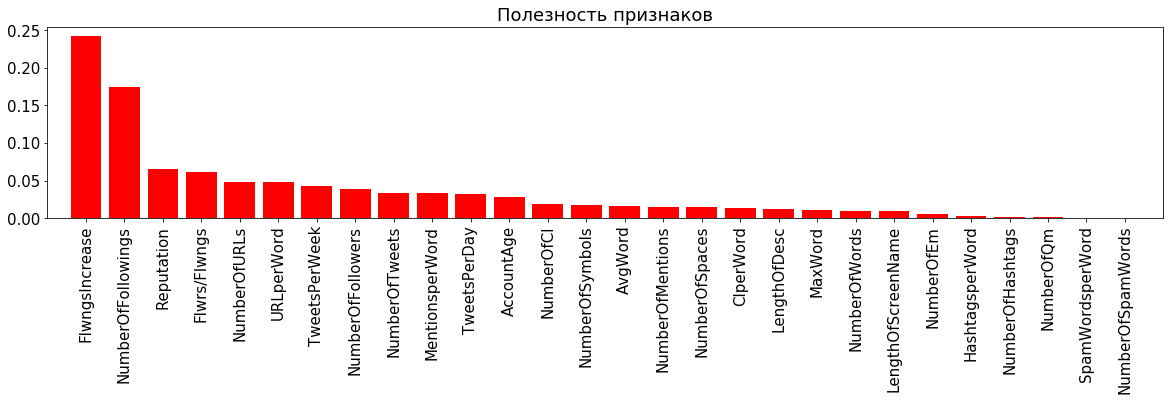

In [54]:
importances  = best_estimator.feature_importances_
std = np.std([best_estimator.feature_importances_ for tree in best_estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest

plt.rcParams['figure.figsize'] = (20,7)
plt.rcParams['font.size'] = 15 
plt.figure()
plt.title("Полезность признаков")
plt.bar(range(X_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), list(X_test[indices]), rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
plt.gcf().subplots_adjust(bottom=0.5)
#plt.setp(legend.get_title(),fontsize='xx-small')
plt.savefig("featureImportance.png")
plt.show()

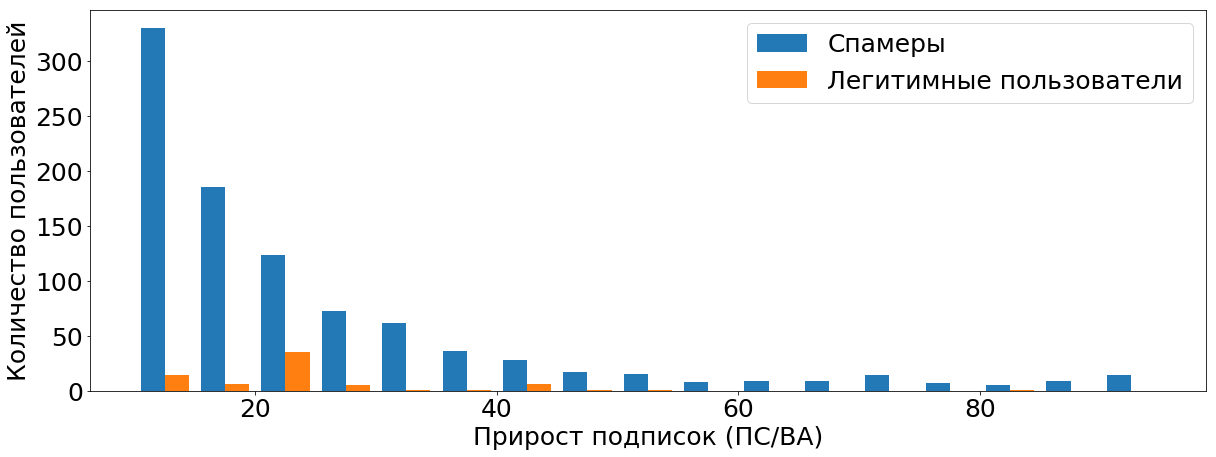

In [55]:
plt.rcParams['figure.figsize'] = (20,7)
plt.rcParams['font.size'] = 25   

data0=data
plt.hist([data0[data0.IsSpammer==1].FlwngsIncrease.values,
          data0[data0.IsSpammer==0].FlwngsIncrease.values],
          label = ['Спамеры','Легитимные пользователи'],
          alpha = .99,
          bins=range(10,100, 5))
plt.legend()
plt.xlabel("Прирост подписок (ПС/ВА)")
plt.ylabel("Количество пользователей")
plt.savefig("flwngsincrease.png")
plt.show()

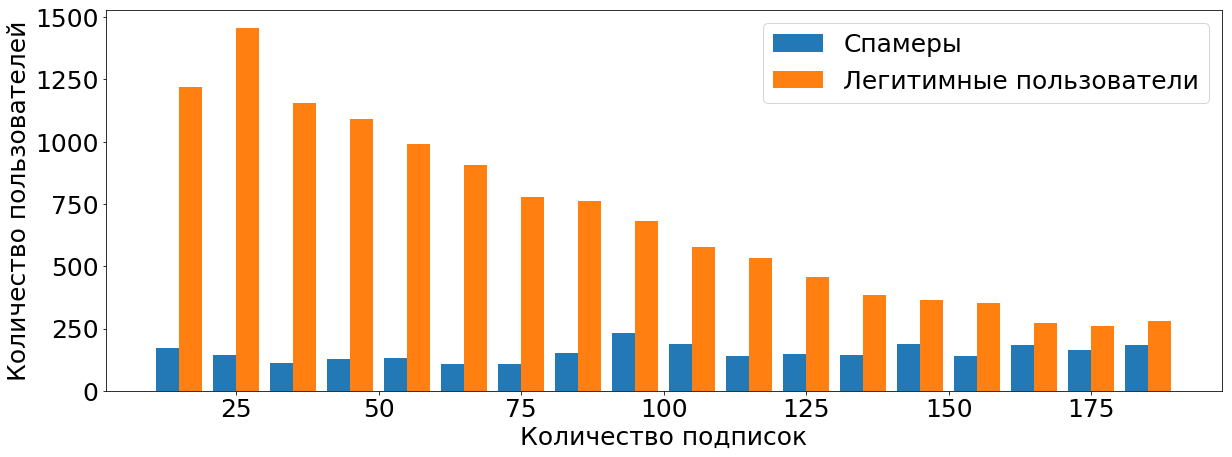

In [56]:
plt.rcParams['figure.figsize'] = (20,7)
plt.rcParams['font.size'] = 25   

data0=data
plt.hist([data0[data0.IsSpammer==1].NumberOfFollowings.values,
          data0[data0.IsSpammer==0].NumberOfFollowings.values],
          label = ['Спамеры','Легитимные пользователи'],
          alpha = .99,
          bins=range(10,200, 10))
plt.legend()
plt.xlabel("Количество подписок")
plt.ylabel("Количество пользователей")
plt.savefig("NumberOfFollowings.png")
plt.show()

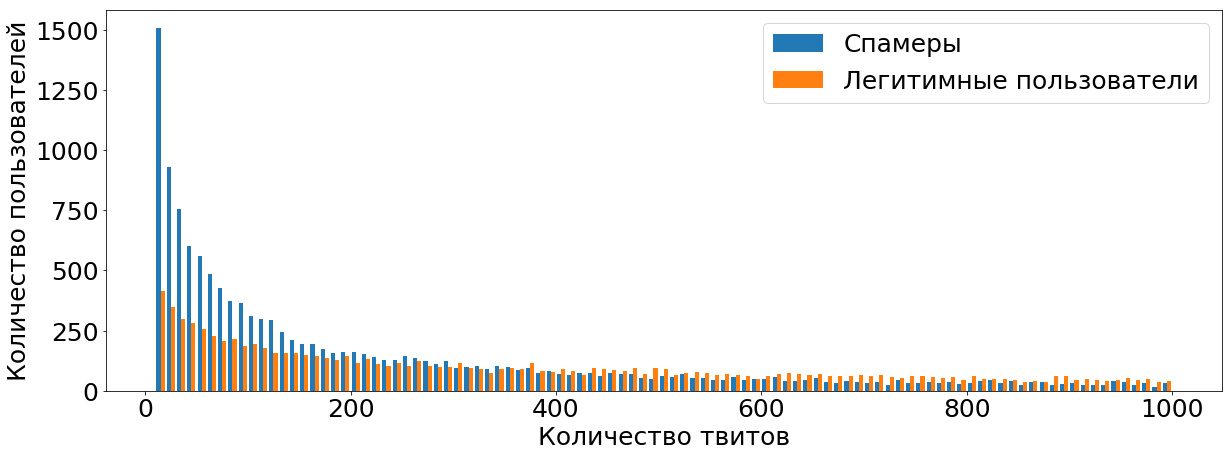

In [57]:
plt.rcParams['figure.figsize'] = (20,7)
plt.rcParams['font.size'] = 25   

data0=data
plt.hist([data0[data0.IsSpammer==1].NumberOfTweets.values,
          data0[data0.IsSpammer==0].NumberOfTweets.values],
          label = ['Спамеры','Легитимные пользователи'],
          alpha = .99,
          bins=range(10,1010, 10))
plt.legend()
plt.xlabel("Количество твитов")
plt.ylabel("Количество пользователей")
#plt.savefig("reputation.png")
plt.show()

In [59]:
def result(row):
    if not row['IsCorrect'] and row['Actual'] == 0:
        return "FalsePositive"
    elif not row['IsCorrect'] and row['Actual'] == 1:
        return "FalseNegative"
    elif row['IsCorrect'] and row['Actual'] == 1:
        return "TruePositive"
    elif row['IsCorrect'] and row['Actual'] == 0:
        return "TrueNegative"

In [60]:
Compare = {"Predicted" : Y_pred, 'Actual': Y_test, 'IsCorrect': Y_pred == Y_test}
Tests = pd.DataFrame(data=Compare)
Tests['Result'] = Tests.apply(result,axis=1) 
Tests

,Actual,IsCorrect,Predicted,Result
UserID,,,,
39981903,0,True,0,TrueNegative
37988259,0,True,0,TrueNegative
103811363,1,True,1,TruePositive
106455845,1,True,1,TruePositive
20559338,0,True,0,TrueNegative
63708784,0,True,0,TrueNegative
151711487,1,True,1,TruePositive
29036202,0,True,0,TrueNegative
103602215,1,True,1,TruePositive


In [61]:
Tests.loc[Tests['Result'] == 'FalsePositive']

,Actual,IsCorrect,Predicted,Result
UserID,,,,
87396839,0,False,1,FalsePositive
92884871,0,False,1,FalsePositive
39803028,0,False,1,FalsePositive
92432557,0,False,1,FalsePositive
32076507,0,False,1,FalsePositive
15047836,0,False,1,FalsePositive
48138419,0,False,1,FalsePositive
46133557,0,False,1,FalsePositive
70238402,0,False,1,FalsePositive


In [62]:
FalsePositives = data.loc[Tests.loc[Tests['Result'] == 'FalsePositive'].index]  # .to_latex()
URLS = 100. * FalsePositives.NumberOfURLs.value_counts() / len(FalsePositives.NumberOfURLs)
URLS

1    60.851506
0    38.213915
2     0.830737
5     0.103842
Name: NumberOfURLs, dtype: float64

In [63]:
TweetExamples = FalsePositives.loc[[83076908,58205927,27059567,27094415,674433]]
TweetExamples.Tweet

UserID
83076908                                                  NaN
58205927                                                  NaN
27059567    Need A Job? Hiring Today - Job Requires: Basic...
27094415                                                  NaN
674433      We are recommending Essential Travel for affor...
Name: Tweet, dtype: object

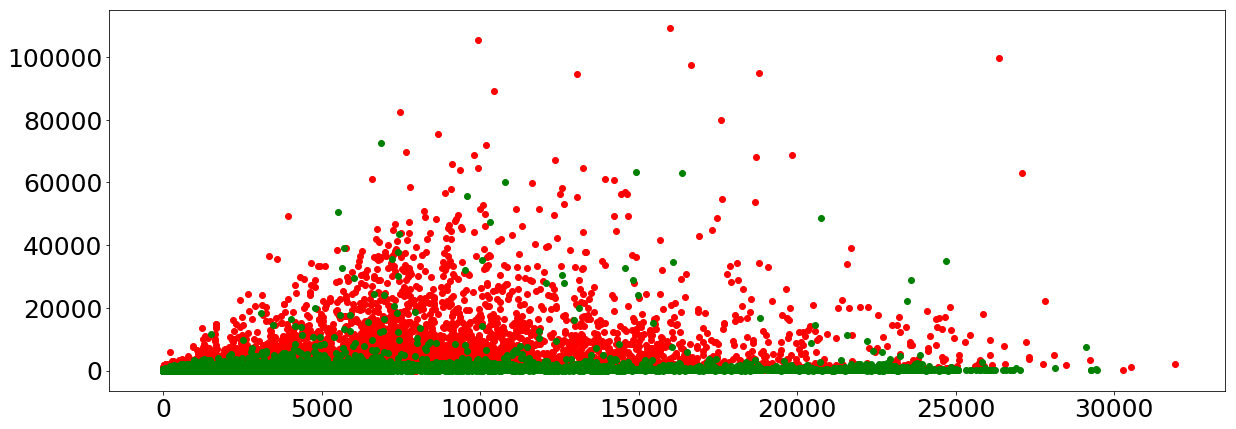

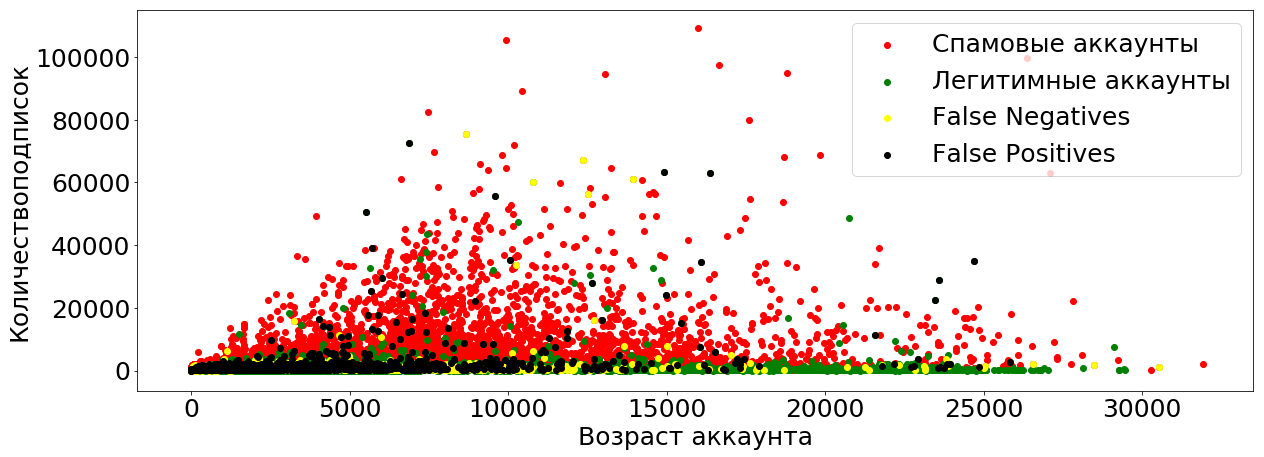

In [64]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x = data['AccountAge'].loc[data['IsSpammer'] == 1], y=data['NumberOfFollowings'].loc[data['IsSpammer'] == 1],   color = 'Red', label = "Спамовые аккаунты")
ax1.scatter(x = data['AccountAge'].loc[data['IsSpammer'] == 0], y=data['NumberOfFollowings'].loc[data['IsSpammer'] == 0],  color = 'Green', label= "Легитимные аккаунты")
ax1.scatter(x = data['AccountAge'].loc[Tests.loc[Tests['Result'] == 'FalseNegative'].index], y=data['NumberOfFollowings'].loc[Tests.loc[Tests['Result'] == 'FalseNegative'].index],  color = 'Yellow', label= "False Negatives")
ax1.scatter(x = data['AccountAge'].loc[Tests.loc[Tests['Result'] == 'FalsePositive'].index], y=data['NumberOfFollowings'].loc[Tests.loc[Tests['Result'] == 'FalsePositive'].index], color = 'Black', label= "False Positives")
plt.xlabel("Возраст аккаунта")
plt.ylabel("Количествоподписок")
plt.legend(loc='upper right');
plt.savefig("ageincreasewitherrors")
plt.show()

## Feature extraction time

In [65]:
data = pd.concat([spammers, nonspammers])
data = data[:9000]

In [66]:
%%time
#User features

# LengthOfScreenName
# LengthOfDescriptionInUserProfile
# NumberofFollowings
# NumberofFollowers
# NumberofTweets
data["ProfileCreatedAt"] = pd.to_datetime(data["ProfileCreatedAt"])
data["ProfileCollectedAt"] = pd.to_datetime(data["ProfileCollectedAt"])
data["AccountAge"] = (data["ProfileCollectedAt"] - data["ProfileCreatedAt"]).astype('timedelta64[h]')

data["Flwrs/Flwngs"] = data["NumberOfFollowers"].divide(data["NumberOfFollowings"], fill_value=True)
data["Flwrs/Flwngs"].replace(np.inf, data["NumberOfFollowers"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["Reputation"] = data["NumberOfFollowers"].divide((data["NumberOfFollowers"] + data["NumberOfFollowings"]), fill_value=True)
data["Reputation"].replace(np.inf, data["NumberOfFollowers"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["FlwngsIncrease"] = data["NumberOfFollowings"].divide(data["AccountAge"])
data["FlwngsIncrease"].replace(np.inf, data["NumberOfFollowings"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["TweetsPerDay"]  = data["NumberOfTweets"].divide((data["AccountAge"] / 24), fill_value=True)
data["TweetsPerDay"].replace(np.inf, data["NumberOfTweets"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["TweetsPerWeek"]  = data["NumberOfTweets"].divide((data["AccountAge"] / (24 * 7)), fill_value=True)
data["TweetsPerWeek"].replace(np.inf, data["NumberOfTweets"], inplace = True)
data.replace(np.nan, 0, inplace = True)

CPU times: user 3.1 s, sys: 88.1 ms, total: 3.19 s
Wall time: 3.24 s


In [68]:
data["TweetWordsList"] = data["Tweet"].str.split()
data['CleanTweet'] = data.apply(clean_tweet,axis=1)
data["CleanTweetWordsList"] = data["CleanTweet"].str.split()

In [69]:
%%time
#Content features

data["NumberOfWords"] = data["CleanTweet"].str.count(' ') + 1
data["NumberOfWords"].replace(1, 0, inplace = True)

data["NumberOfSymbols"] = data["Tweet"].str.len()

data["NumberOfSpaces"] = data["Tweet"].str.count(' ')

data["NumberOfCl"] = data.apply(count_uppercases,axis=1)

data["ClperWord"] = data["NumberOfCl"].divide(data["NumberOfWords"])
data["ClperWord"].replace(np.inf, data["NumberOfCl"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data['MaxWord'] = data.apply(longest_word,axis=1)

data['AvgWord'] = data.apply(average_word,axis=1)

data["NumberOfEm"] = data["Tweet"].str.count('\!')

data["NumberOfQm"] = data["Tweet"].str.count('\?')

data["NumberOfURLs"] = data.apply(count_urls,axis=1)

data["URLperWord"] = data["NumberOfURLs"].divide(data["NumberOfWords"])
data["URLperWord"].replace(np.inf, data["NumberOfURLs"], inplace = True)
data.replace(np.nan, 0, inplace = True)


data["NumberOfMentions"] = data.apply(count_mentions,axis=1)

data["MentionsperWord"] = data["NumberOfMentions"].divide(data["NumberOfWords"])
data["MentionsperWord"].replace(np.inf, data["NumberOfMentions"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["NumberOfHashtags"] = data.apply(count_hashtags,axis=1)

data["HashtagsperWord"] = data["NumberOfHashtags"].divide(data["NumberOfWords"])
data["HashtagsperWord"].replace(np.inf, data["NumberOfHashtags"], inplace = True)
data.replace(np.nan, 0, inplace = True)

data["NumberOfSpamWords"] = data.apply(count_spamwords,axis=1)

data["SpamWordsperWord"] = data["NumberOfSpamWords"].divide(data["NumberOfWords"])
data["SpamWordsperWord"].replace(np.inf, data["NumberOfSpamWords"], inplace = True)
data.replace(np.nan, 0, inplace = True)

CPU times: user 8.88 s, sys: 134 ms, total: 9.02 s
Wall time: 9.13 s
